In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

from src.simpleEDMD import *
import src.dictionary_strategy as d_strategy

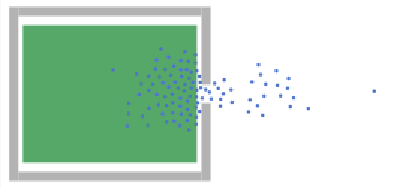

# dataset

In [2]:
df = pd.read_csv('datasets/postvis.traj', delim_whitespace=True)
traj = np.array(df,dtype=float)
# 8 columns
# 0-pedId, 1-simTime, 2-endTime, 3-startX, 4-startY, 5-endX, 6-endY, 7-targetId
df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.100000,0.745379,8.577139,8.601742,9.397920,8.601742,6
1,2,0.100000,0.893789,5.969761,12.684033,6.626429,12.684033,6
2,3,0.100000,0.906596,9.103012,14.466950,9.579383,14.146795,6
3,4,0.100000,0.628872,7.217410,19.891623,7.217410,19.891623,6
4,5,0.100000,0.765057,12.435188,7.360020,13.051691,7.893366,6
...,...,...,...,...,...,...,...,...
14014,26,149.300804,150.158280,98.835150,13.660293,98.835150,13.660293,6
14015,2,149.332328,150.126117,98.864053,12.416538,98.864053,12.416538,6
14016,25,149.616118,150.415670,98.859606,14.865688,98.859606,14.865688,6
14017,14,149.686366,150.345336,98.867966,11.230994,98.867966,11.230994,6


In [3]:
# # analyse first 120 time step
# sim_step = 120
# step_length = 0.4

# data_cm = np.zeros((sim_step, 2))

# for t in range(sim_step):
#     i = np.where((traj[:,1] > step_length*t) & (traj[:,1] <= step_length*(t+1)))
#     if np.isnan(i).all():
#         data_cm[t,:] = data_cm[t-1,:]
#         continue       
#     data_cm[t,0] = np.average(traj[i,3])
#     data_cm[t,1] = np.average(traj[i,4])

In [4]:
sim_step = 120
step_length = 0.4
peds = np.arange(1,101,1)
data_cm = []
last_ped_pos = traj[:100, 3:5]
print(last_ped_pos.shape)
for t in range(sim_step):
    i = np.where((traj[:,1] > step_length*t) & (traj[:,1] <= step_length*(t+1)))
    i = i[0]
    ped_isin = np.isin(peds, traj[i, 0])
    buf_traj = np.vstack((traj[i, 3:5], last_ped_pos[np.logical_not(ped_isin), 0:2]))

    data_cm.append(np.average(buf_traj, axis=0))
    last_ped_pos[(traj[i, 0] - 1).astype(int), :] = traj[i, 3:5]

data_cm = np.array(data_cm)

(100, 2)


In [5]:
X = data_cm[:-1,:]
Y = data_cm[1:,:]

In [6]:
X.shape

(119, 2)

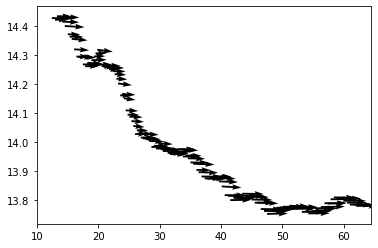

In [7]:
x = X[:,0]
y = X[:,1]
u = (Y[:,0]-X[:,0])/step_length
v = (Y[:,1]-X[:,1])/step_length
plt.quiver(x, y, u, v)
# plt.axis([0, 80, 13, 15])
plt.show()

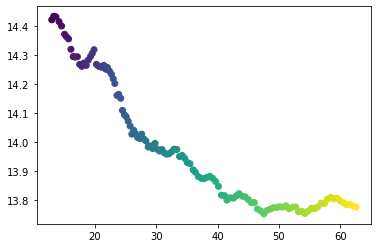

In [13]:
plt.scatter(Y[:, 0], Y[:, 1], c=np.arange(len(x)))
plt.show()

# Koopman

In [8]:
dmap_strategy = d_strategy.dmap_strategy()
bnEDMD = simpleEDMD(X,Y, dmap_strategy)

In [9]:
bnEDMD.compute_koopman_operator()

In [10]:
Y_predicted  = bnEDMD.predict_next_timestep(X).real
MSE = mean_squared_error(Y,Y_predicted)
MSE

0.3507676761608171

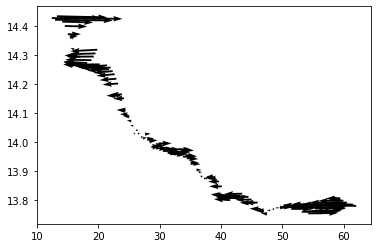

In [11]:
u_predicted = (Y_predicted[:,0]-X[:,0])/step_length
v_predicted = (Y_predicted[:,1]-X[:,1])/step_length
plt.quiver(x, y, u_predicted, v_predicted)
# plt.axis([0, 80, 13, 15])
plt.show()

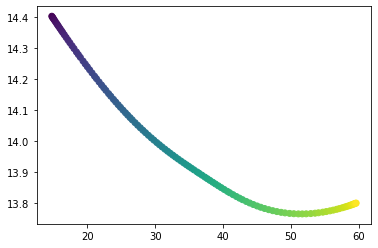

In [14]:
plt.scatter(Y_predicted[:, 0], Y_predicted[:, 1], c=np.arange(len(x)))
plt.show()